In [1]:
import os
import sys
import datetime

import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

from SRModels.deep_learning_models.ESRGAN_model import ESRGAN
from SRModels.loading_methods import load_dataset_as_patches
from SRModels.constants import ESRGAN_PATCH_SIZE, ESRGAN_STRIDE, RANDOM_SEED, ESRGAN_SCALE_FACTOR

c:\Users\bgmanuel\anaconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\bgmanuel\anaconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.

In [2]:
# Enable memory growth (prevents full pre-allocation)
for gpu in tf.config.experimental.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print(f"Memory growth not set: {e}")

In [3]:
HR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/HR"))
LR_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../data/images/LR"))

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
directory = f"models/ESRGAN/ESRGAN_{timestamp}"
grid_figures_directory = f"{directory}/grid_figures"

In [4]:
X, Y = load_dataset_as_patches(HR_ROOT, LR_ROOT, mode="scale", patch_size=ESRGAN_PATCH_SIZE, stride=ESRGAN_STRIDE, scale_factor=ESRGAN_SCALE_FACTOR)

# Reduce dataset size by percentage
X = X[:int(len(X) * 0.5)]
Y = Y[:int(len(Y) * 0.5)]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle=True, random_state=RANDOM_SEED)

print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (45761, 24, 24, 3), Y_train shape: (45761, 48, 48, 3)
X_val shape: (5085, 24, 24, 3), Y_val shape: (5085, 48, 48, 3)
X_test shape: (5650, 24, 24, 3), Y_test shape: (5650, 48, 48, 3)


X_train range: [0.0000, 1.0000]
Y_train range: [0.0000, 1.0000]
NaN in X_train: False, NaN in Y_train: False


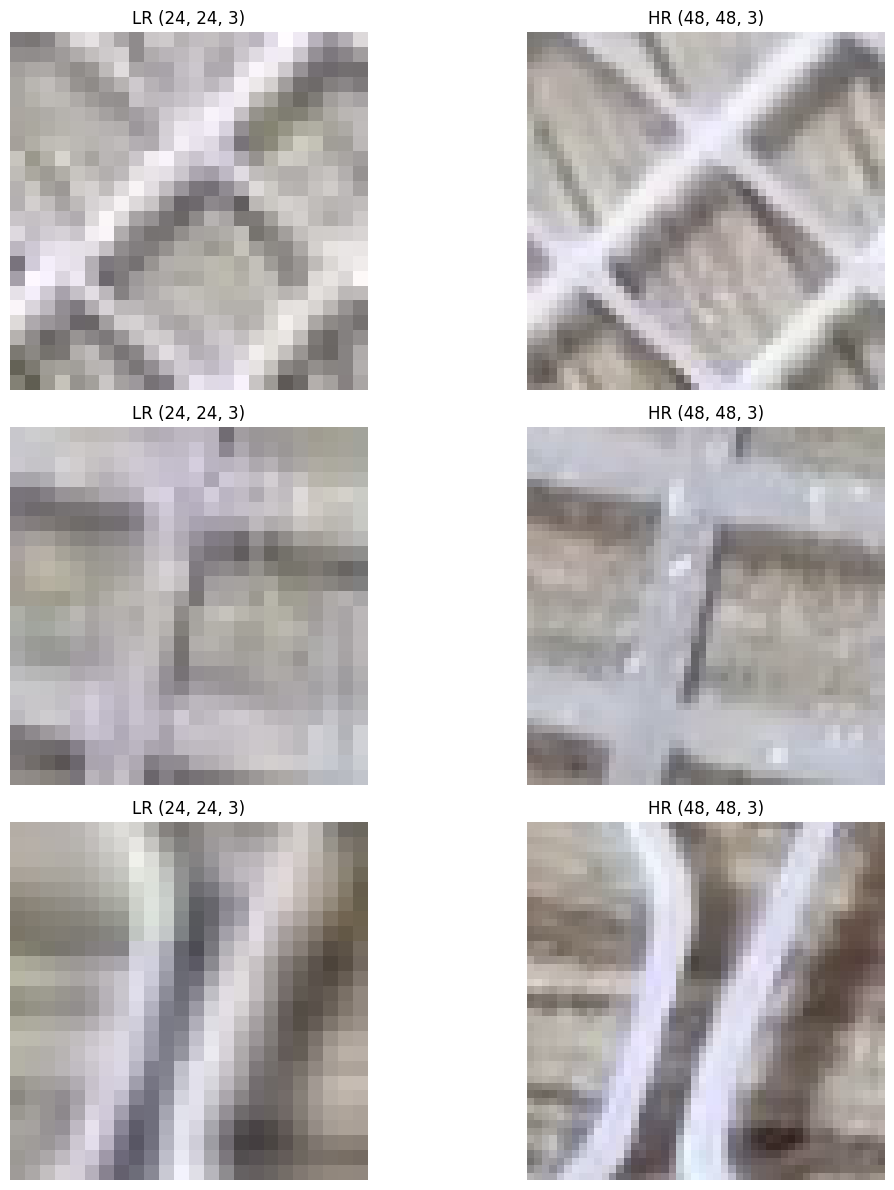

In [5]:
# Verificar rangos
print(f"X_train range: [{np.min(X_train):.4f}, {np.max(X_train):.4f}]")
print(f"Y_train range: [{np.min(Y_train):.4f}, {np.max(Y_train):.4f}]")
print(f"NaN in X_train: {np.isnan(X_train).any()}, NaN in Y_train: {np.isnan(Y_train).any()}")

# Visualizar algunos pares aleatorios
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for i in range(3):
    idx = np.random.randint(0, len(X_train))
    axes[i, 0].imshow(X_train[idx])
    axes[i, 0].set_title(f"LR {X_train[idx].shape}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(Y_train[idx])
    axes[i, 1].set_title(f"HR {Y_train[idx].shape}")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
BATCH_SIZE = 16     # Ajustar según memoria GPU

# Se define también el dataset de test (solo para evaluación posterior)
# Se normaliza a [-1,1] para que coincida con lo usado en entrenamiento
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(BATCH_SIZE)
test_dataset = test_dataset.map(lambda x,y: (x*2.0 - 1.0, y*2.0 - 1.0), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [7]:
model = ESRGAN()

model.setup_model(
    scale_factor=2, 
    growth_channels=8, 
    num_rrdb_blocks=4, 
    input_shape=X_train.shape[1:],
    output_shape=Y_train.shape[1:],
    from_trained=False
)

GENERATOR SUMMARY
Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lr_input (InputLayer)          [(None, 24, 24, 3)]  0           []                               
                                                                                                  
 initial_conv (Conv2D)          (None, 24, 24, 64)   1792        ['lr_input[0][0]']               
                                                                                                  
 rrdb_0_dense1_conv1 (Conv2D)   (None, 24, 24, 8)    4616        ['initial_conv[0][0]']           
                                                                                                  
 rrdb_0_dense1_concat1 (Concate  (None, 24, 24, 72)  0           ['initial_conv[0][0]',           
 nate)                                                            'rrdb_

In [8]:
# Train ESRGAN and capture callbacks for metrics
epoch_losses, time_cb, mem_cb = model.fit(
    X_train=X_train, 
    Y_train=Y_train, 
    X_val=X_val, 
    Y_val=Y_val,
    epochs=10, 
    batch_size=BATCH_SIZE,
    save_dir=grid_figures_directory,
)

Training on GPU: ['/physical_device:GPU:0']
Epoch 1/10
  Step 10/2861 G_loss=77.1299 D_loss=1.3861 PSNR=20.80 SSIM=0.4767
  Step 20/2861 G_loss=64.8010 D_loss=1.3858 PSNR=21.03 SSIM=0.5396
  Step 30/2861 G_loss=42.3031 D_loss=1.3859 PSNR=23.45 SSIM=0.6791
  Step 40/2861 G_loss=40.7301 D_loss=1.3858 PSNR=24.40 SSIM=0.7367
  Step 50/2861 G_loss=36.1660 D_loss=1.3856 PSNR=25.03 SSIM=0.7329
  Step 60/2861 G_loss=31.2387 D_loss=1.3853 PSNR=25.10 SSIM=0.7129
  Step 70/2861 G_loss=32.0776 D_loss=1.3855 PSNR=25.27 SSIM=0.7120
  Step 80/2861 G_loss=35.0409 D_loss=1.3856 PSNR=25.50 SSIM=0.7352
  Step 90/2861 G_loss=23.4496 D_loss=1.3852 PSNR=27.27 SSIM=0.7316
  Step 100/2861 G_loss=25.3239 D_loss=1.3848 PSNR=28.22 SSIM=0.7728
  Step 110/2861 G_loss=39.7584 D_loss=1.3822 PSNR=24.92 SSIM=0.7125
  Step 120/2861 G_loss=28.7831 D_loss=1.3822 PSNR=25.88 SSIM=0.7484
  Step 130/2861 G_loss=27.4665 D_loss=1.3810 PSNR=26.88 SSIM=0.7602
  Step 140/2861 G_loss=28.8488 D_loss=1.3788 PSNR=25.29 SSIM=0.7499
  

c:\Users\bgmanuel\anaconda3\envs\py310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bgmanuel\anaconda3\envs\py310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


  Validation -> PSNR: 28.15, SSIM: 0.7935, G_loss: 21.9002
Epoch 2/10
  Step 10/2861 G_loss=20.4686 D_loss=1.2606 PSNR=29.81 SSIM=0.8194
  Step 20/2861 G_loss=24.2543 D_loss=1.2115 PSNR=27.49 SSIM=0.7784
  Step 30/2861 G_loss=23.8063 D_loss=1.1927 PSNR=28.22 SSIM=0.7999
  Step 40/2861 G_loss=16.6016 D_loss=1.1497 PSNR=28.03 SSIM=0.7515
  Step 50/2861 G_loss=23.2894 D_loss=1.1410 PSNR=27.22 SSIM=0.7834
  Step 60/2861 G_loss=19.6096 D_loss=1.2583 PSNR=27.97 SSIM=0.8104
  Step 70/2861 G_loss=23.6748 D_loss=1.2093 PSNR=28.01 SSIM=0.8074
  Step 80/2861 G_loss=22.7609 D_loss=1.1650 PSNR=27.82 SSIM=0.7688
  Step 90/2861 G_loss=18.1321 D_loss=1.1749 PSNR=28.77 SSIM=0.7988
  Step 100/2861 G_loss=18.6421 D_loss=1.1499 PSNR=27.45 SSIM=0.7801
  Step 110/2861 G_loss=26.5923 D_loss=1.0870 PSNR=26.01 SSIM=0.7207
  Step 120/2861 G_loss=18.4352 D_loss=1.2599 PSNR=29.05 SSIM=0.8320
  Step 130/2861 G_loss=23.5379 D_loss=1.2223 PSNR=26.96 SSIM=0.7882
  Step 140/2861 G_loss=23.3075 D_loss=1.1845 PSNR=26.78

In [9]:
results = model.evaluate(test_dataset)

metrics_dict = {
    "eval_loss": float(results["avg_g_loss"]),
    "eval_psnr": float(results["avg_psnr"]),
    "eval_ssim": float(results["avg_ssim"]),
    "final_train_loss": epoch_losses.get("g_loss", None)[-1] if epoch_losses.get("g_loss", None) else None,
    "final_val_loss": epoch_losses.get("val_g_loss", None),
    "final_train_psnr": epoch_losses.get("psnr", None)[-1] if epoch_losses.get("psnr", None) else None,
    "final_val_psnr": epoch_losses.get("val_psnr", None),
    "final_train_ssim": epoch_losses.get("ssim", None)[-1] if epoch_losses.get("ssim", None) else None,
    "final_val_ssim": epoch_losses.get("val_ssim", None),
    "epoch_time_sec": time_cb.mean_time_value(),
    "memory": mem_cb.as_dict()
}

Evaluating model on test dataset...
Evaluation Results:
  Average PSNR: 28.8198
  Average SSIM: 0.8091
  Average G Loss: 17.5548


In [10]:
# Save the trained model
model.save(directory=directory, timestamp=timestamp)

Generator model saved to models/ESRGAN/ESRGAN_20250910_091210\ESRGAN_generator_x2_20250910_091210.h5
Discriminator model saved to models/ESRGAN/ESRGAN_20250910_091210\ESRGAN_discriminator_x2_20250910_091210.h5


In [11]:
# Save evaluation/time/memory metrics next to the model
metrics_path = os.path.abspath(os.path.join(os.getcwd(), f"models/ESRGAN/ESRGAN_{timestamp}/ESRGAN_{timestamp}_metrics.pkl"))

with open(metrics_path, "wb") as f:
    pickle.dump(metrics_dict, f)
    
print(f"Saved metrics to {metrics_path}")

Saved metrics to c:\Users\bgmanuel\InteligenciaArtificial\MasterInteligenciaArtificial\Periodo2\TFM\Super-Resolution-Images-for-3D-Printing-Defect-Detection\SRModels\deep_learning_models\models\ESRGAN\ESRGAN_20250910_091210\ESRGAN_20250910_091210_metrics.pkl
